In [2]:
%load_ext rpy2.ipython

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from tifffile import TiffFile

In [3]:
tif_path = 'data/VIIRS/SVDNB_npp_20161201-20161231_75N180W_vcmcfg_v10_c201701271136.cf_cvg.tif'
tif_out_path = 'data/VIIRS/generated/'

In [5]:
with TiffFile(tif_path) as tif:
    image = 1 / tif.asarray()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [6]:
equator_circumfence = 40030 # km, obviously

## Average Stable Lights

In [270]:
tif_paths = [
    'data/VIIRS/F101992.v4/F101992.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101993.v4/F101993.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F101994.v4/F101994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121994.v4/F121994.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121995.v4/F121995.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F121996.v4/F121996.v4b_web.stable_lights.avg_vis.tif',
    'data/VIIRS/F182013.v4/F182013.v4c_web.stable_lights.avg_vis.tif'
]
t_years = len(tif_paths)
n = 16801
m = 43201

images = np.zeros((len(tif_paths),n,m))
                  
for i, p in enumerate(tif_paths):
    with TiffFile(p) as tif:
        images[i] = tif.asarray()

$$
\begin{aligned}
d &= 2 \text{  since it's an image} \\
k_d&: \text{  integer that can divide } k_d \in {n,m}\\
\delta_d&: \text{  integer that can divide } k_d \implies d\\
L_{n \times m}&: \text{ pixel luminosity } l \in (0,1)\\
S &: s_i \in \mathbb{L}_{n \times m}
\end{aligned}
$$

### Extracting Subimages (Convolutional Style)

In [271]:
def convolve_coordinates(image, step_size = (150,150), sub_image_shape = (300,300)):
    passes = [int(image.shape[i]/step_size[i]-sub_image_shape[i]/step_size[i]+1) for i in range(dimension)]
    sub_image_coordinates = np.zeros((*passes,2,2))
    for i in range(passes[0]):
        step_i = i*step_size[0]
        for j in range(passes[1]):
            step_j = j*step_size[1]
            sub_image_coordinates[i,j] = [
                [step_i,step_i+sub_image_shape[0]],
                [step_j,step_j+sub_image_shape[1]]
            ]
            
    return sub_image_coordinates.reshape(passes[0]*passes[1],2,2)

In [272]:
sub_img_pxl = np.zeros((t_years, 31857, 2, 2))

for t, img in enumerate(images):
    sub_img_pxl[t] = convolve_coordinates(img)
    
sub_img_pxl.shape

(6, 31857, 2, 2)

Function using coordinates to retrieve information (faster)

In [273]:
def retrieve_sub_img(image,pxl):
    return image[img_pxl[0,0]:img_pxl[0,1],
                 img_pxl[1,0]:img_pxl[1,1]]

Construct dataframe

In [301]:
X_df = pd.DataFrame(columns=['i','f','t','mean_luminosity','pxltl','pxlbl','pxltr','pxlbr'])

for t in range(t_years):
    for i, img_pxl in enumerate(sub_img_pxl[t,10000:10500]):
        X_df = X_df.append(pd.DataFrame([[
            str(i) + ' ' + str(t),
            str(i),
            t,
            np.mean(retrieve_sub_img(images[t],img_pxl)),
            img_pxl[0,0],
            img_pxl[0,1],
            img_pxl[1,0],
            img_pxl[1,1],
        ]],
            columns=['i','f','t','mean_luminosity','pxltl','pxlbl','pxltr','pxlbr'],
            index=[tif_paths[t][-52:-45]+' '+str(i)]
        ))
        
X_df.to_csv('data/features.csv',index=False)
X_df = X_df.set_index(['i'])
X_df.head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


,f,t,mean_luminosity,pxltl,pxlbl,pxltr,pxlbr
i,,,,,,,
0 0,0,0.0,0.003989,5100.0,5400.0,36300.0,36600.0
1 0,1,0.0,0.000178,5100.0,5400.0,36450.0,36750.0
2 0,2,0.0,0.000300,5100.0,5400.0,36600.0,36900.0
3 0,3,0.0,0.005211,5100.0,5400.0,36750.0,37050.0
4 0,4,0.0,0.014311,5100.0,5400.0,36900.0,37200.0


Only very few of the subimages contain a lot of lighting. This is good since we only want to extract areas with lots of luminosity information.

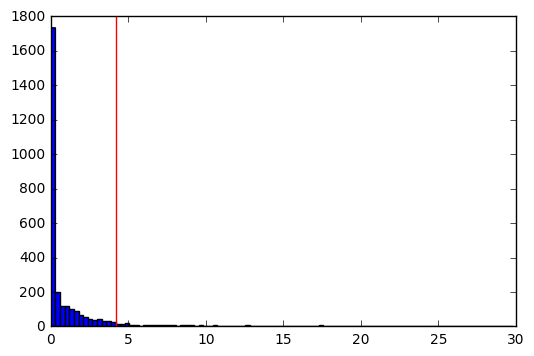

In [275]:
plt.hist(X_df['mean_luminosity'], bins=100)
plt.axvline(np.percentile(X_df['mean_luminosity'],90),color="red")
plt.show()

Lets find the brightest spots on earth 
* This really needs coordinates

In [302]:
X_df = X_df.sort('mean_luminosity',ascending=False)
X_df.head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,f,t,mean_luminosity,pxltl,pxlbl,pxltr,pxlbr
i,,,,,,,
213 5,213,5.0,20.989422,5250.0,5550.0,25200.0,25500.0
285 5,285,5.0,18.375056,5250.0,5550.0,36000.0,36300.0
284 5,284,5.0,15.425867,5250.0,5550.0,35850.0,36150.0
249 5,249,5.0,14.591756,5250.0,5550.0,30600.0,30900.0
410 5,410,5.0,14.002633,5400.0,5700.0,11700.0,12000.0


In [303]:
X_df.groupby('f').var().sort('mean_luminosity',ascending=False)['mean_luminosity'].head()

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


f
285    31.823715
284    23.539272
213    21.790467
212     9.923177
249     9.349643
Name: mean_luminosity, dtype: float64

In [306]:
location_change = X_df[X_df['f'] == '213'].sort('t')
location_change

/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,f,t,mean_luminosity,pxltl,pxlbl,pxltr,pxlbr
i,,,,,,,
213 0,213,0.0,8.647522,5250.0,5550.0,25200.0,25500.0
213 1,213,1.0,9.101011,5250.0,5550.0,25200.0,25500.0
213 2,213,2.0,9.403800,5250.0,5550.0,25200.0,25500.0
213 3,213,3.0,10.578000,5250.0,5550.0,25200.0,25500.0
213 4,213,4.0,11.465000,5250.0,5550.0,25200.0,25500.0
213 5,213,5.0,20.989422,5250.0,5550.0,25200.0,25500.0


/Users/jpw/Development/ganter/ganv/lib/python3.5/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


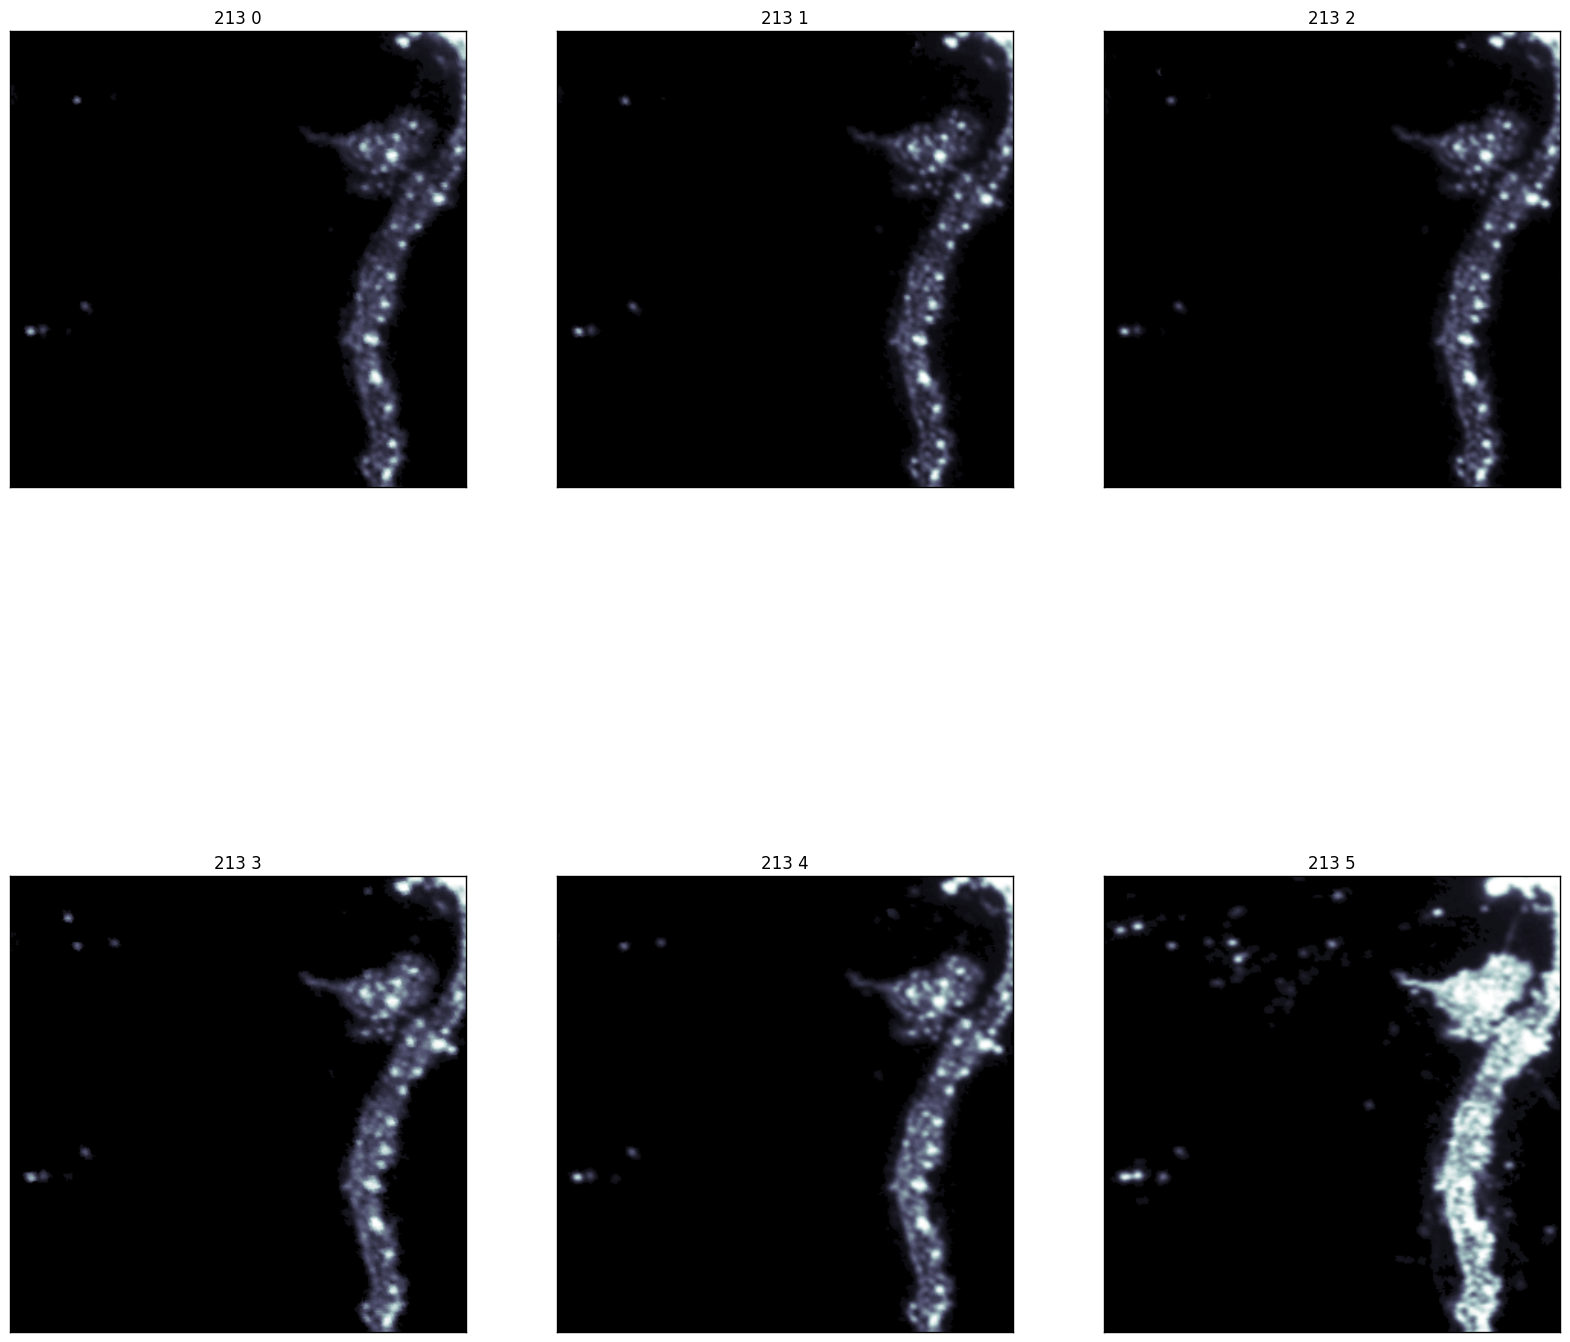

In [307]:
fig, ax = plt.subplots(2,3,figsize=(20,20))
for i, axi in enumerate(ax.flat):
    sub_img = retrieve_sub_img(images[i],
                     [
                         [location_change['pxltl'][i],location_change['pxlbl'][i]],
                         [location_change['pxltr'][i],location_change['pxlbr'][i]]
                     ])
    axi.imshow(sub_img,cmap='bone',)
    axi.set(xticks=[], yticks=[],title=location_change.index[i])

### Calculate Luminosity Change over time period
$$
\mathbb{L}_{i+1} - \mathbb{L}_{i} = \mathbb{L}_{\delta} \text{ luminosity delta}
$$

Lets find Barcelona and compare (1992 to 1993). Not a lot happened, but checkout 2013!!!

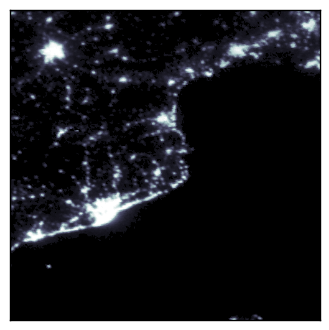

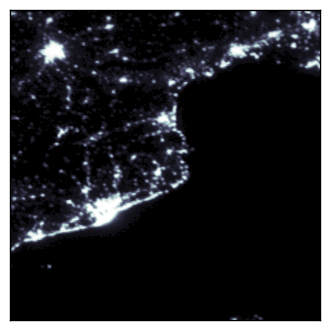

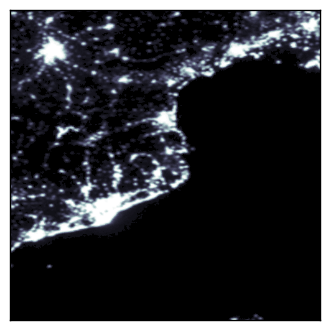

In [4]:
for i, image in enumerate(images):
#     plt.imshow(image[3500:4500,21500:22500], cmap='bone')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    plt.imshow(image[3700:4200,21700:22200], cmap='bone')
    plt.xticks([])
    plt.yticks([])
    plt.show()
#     plt.imshow(image[3970:4070,21800:21900], cmap='bone')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

Barcelona Luminosity Change at different levels between 1992 and 2013

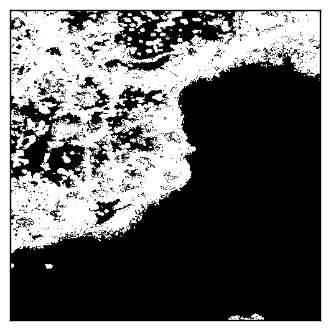

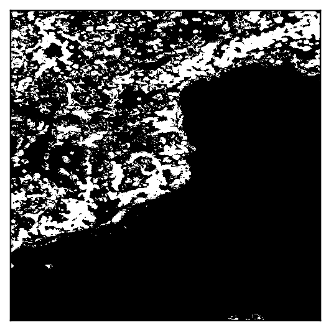

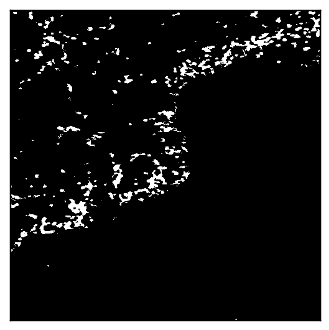

In [11]:
plt.imshow(abs(images[0][3700:4200,21700:22200] - images[-1][3700:4200,21700:22200]) > .2, cmap='bone')
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(abs(images[0][3700:4200,21700:22200] - images[-1][3700:4200,21700:22200]) > 5, cmap='bone')
plt.xticks([])
plt.yticks([])
plt.show()
plt.imshow(abs(images[0][3700:4200,21700:22200] - images[-1][3700:4200,21700:22200]) > 15, cmap='bone')
plt.xticks([])
plt.yticks([])
plt.show()

Generalise for features (general measure of change)

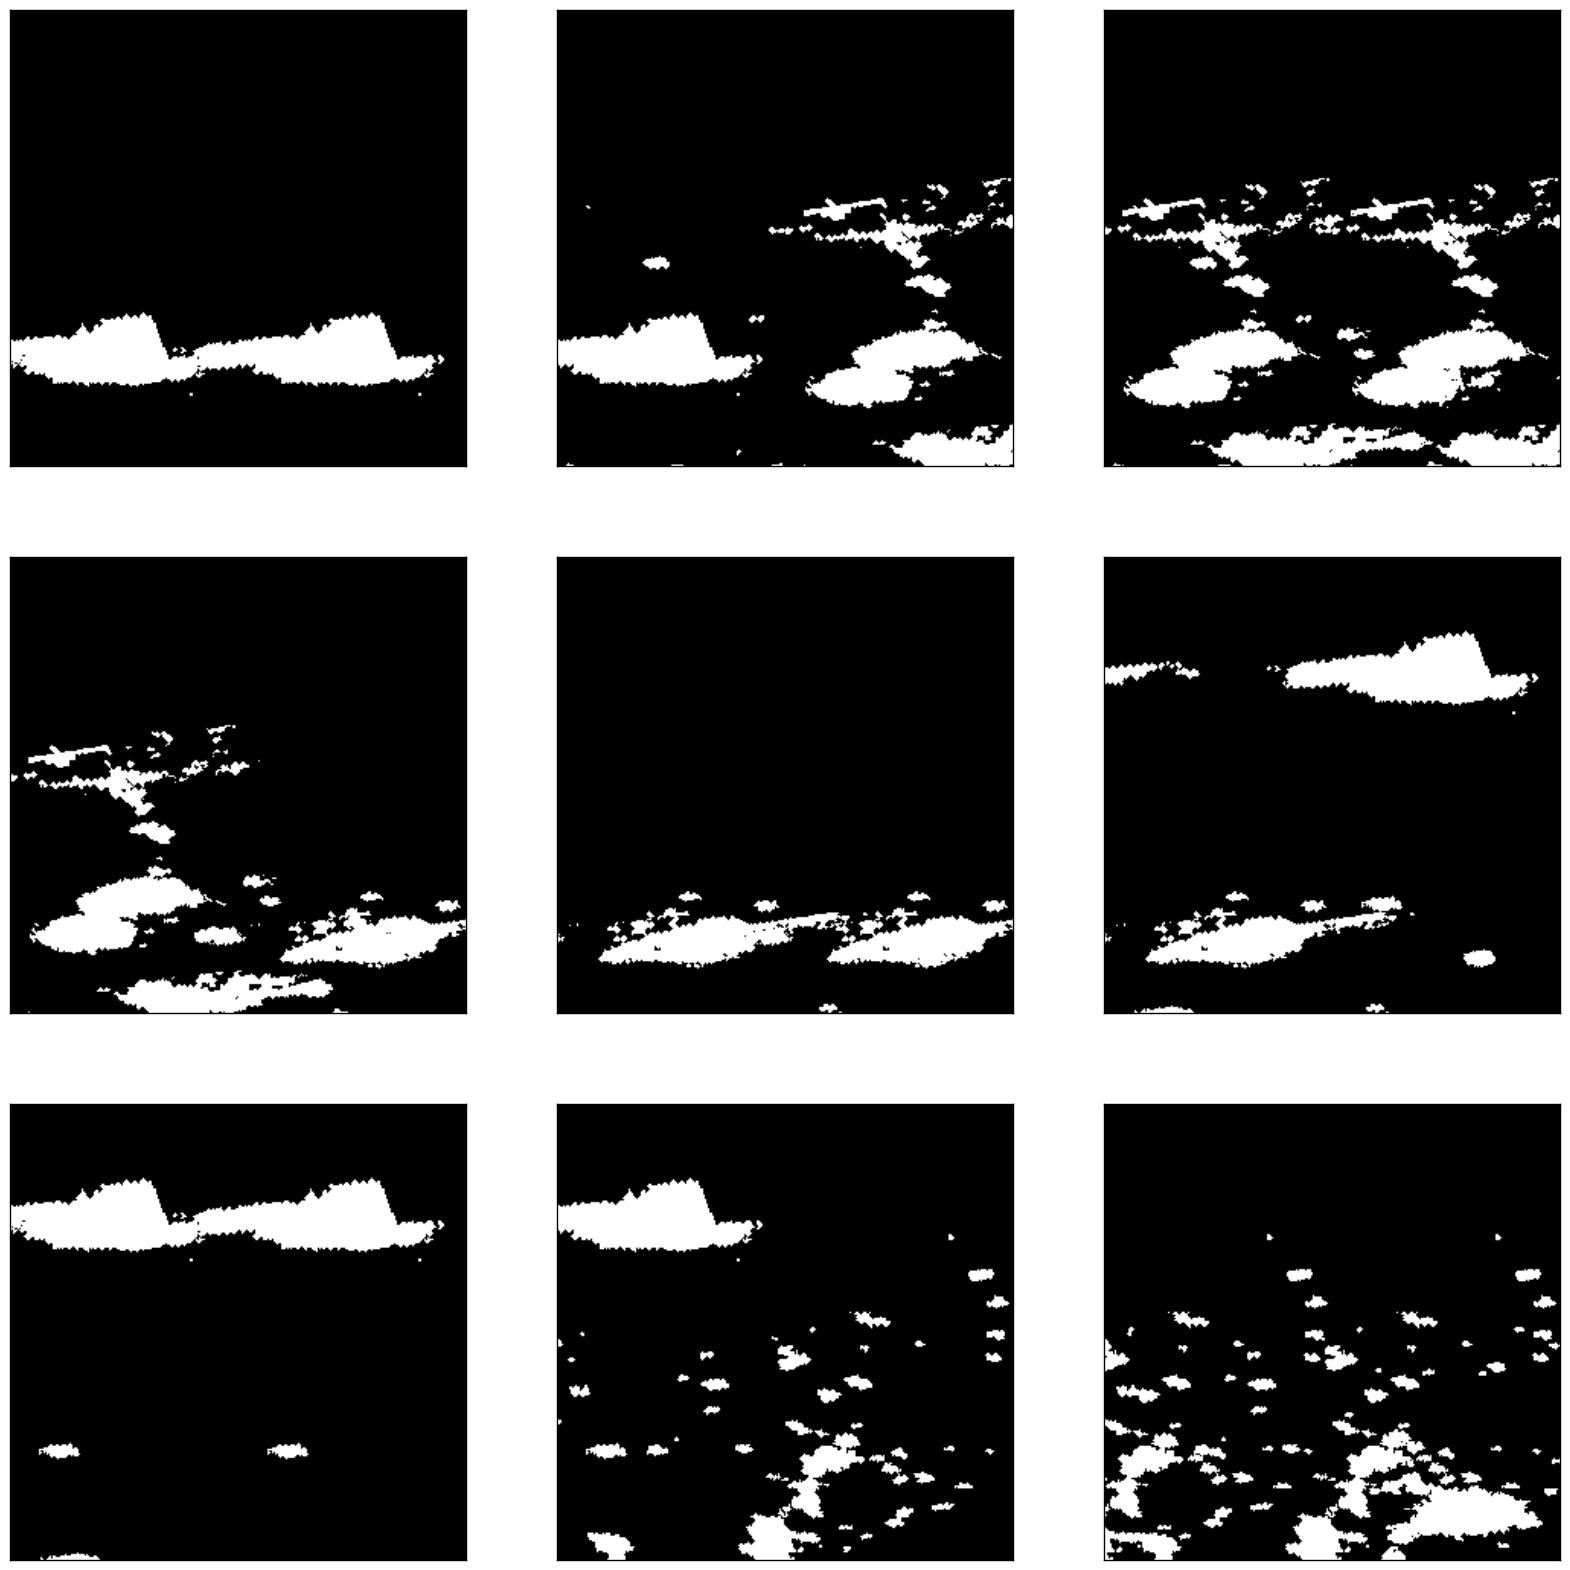

In [48]:
fig, ax = plt.subplots(3,3,figsize=(20,20))
for i, axi, in enumerate(ax.flat):
    axi.imshow(selected_simages[i] - selected_simages[i+1] != 0, cmap = 'bone')
    axi.set(xticks=[], yticks=[])